## HW4-1: Random Matrix Eigenvalues Distribution

**Task**: Study the distribution of eigenvalues of random matrices.

**Steps**:
1. Generate **93 random 32×32** matrices using `np.random.randn(32, 32)`
2. Extract eigenvalues for each matrix using `np.linalg.eig()`
3. Normalize eigenvalues by dividing by √32
4. Plot all eigenvalues on the complex plane (`plt.scatter`)
5. Observe the circular distribution (circular law)

**Expected Result**: Eigenvalues should be distributed in a circle with radius ≈ 1.


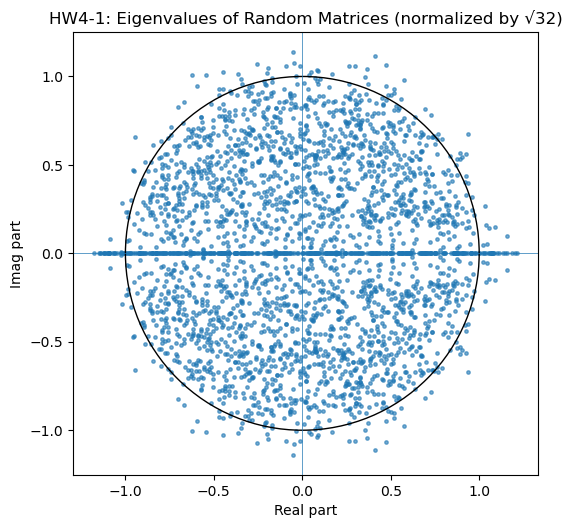

In [1]:

import numpy as np
import matplotlib.pyplot as plt

# Reproducibility
rng = np.random.default_rng(42)

n_mats = 93
n = 32
scale = np.sqrt(n)

all_eigs = []

for _ in range(n_mats):
    A = rng.standard_normal((n, n))
    w = np.linalg.eigvals(A)  # eigenvalues only
    all_eigs.append(w / scale)

all_eigs = np.concatenate(all_eigs)

# Plot on the complex plane
plt.figure(figsize=(6, 6))
plt.scatter(all_eigs.real, all_eigs.imag, s=6, alpha=0.6)
circle = plt.Circle((0, 0), 1.0, fill=False, linewidth=1.0)
plt.gca().add_artist(circle)
plt.axhline(0, linewidth=0.5)
plt.axvline(0, linewidth=0.5)
plt.gca().set_aspect('equal', 'box')
plt.title("HW4-1: Eigenvalues of Random Matrices (normalized by √32)")
plt.xlabel("Real part")
plt.ylabel("Imag part")
plt.show()



---

## HW4-2: Gram-Schmidt Orthonormality Comparison

**Task**: Compare your Gram-Schmidt implementation vs NumPy's `qr`.

### Part A – Nearly parallel vectors
We will check orthonormality error: `max |QᵀQ - I|` for both methods.

### Part B – Ill-conditioned matrix
Construct `A = U S Vᵀ` with singular values `[2^{-1}, …, 2^{-80}]`, then compare diagonals of `R`.
**Expected Observation**: Classical Gram-Schmidt shows instability for tiny singular values; NumPy's `qr` is more stable.


Part A – Orthonormality max error
NumPy QR: 2.220e-16
Gram-Schmidt: 2.301e-11


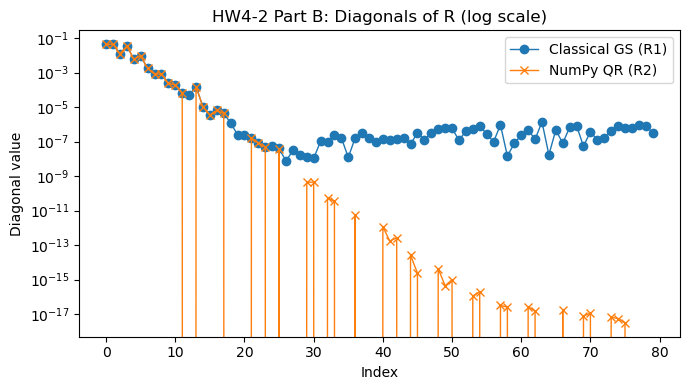

Part B – Orthonormality max error on ill-conditioned A
Classical GS: 1.000e+00
NumPy QR:    8.882e-16


In [2]:

import numpy as np
import matplotlib.pyplot as plt

def gram_schmidt(A: np.ndarray):
    """
    Classical Gram-Schmidt.
    Args:
        A: (m, n) matrix
    Returns:
        Q: (m, n) with (approx) orthonormal columns
        R: (n, n) upper triangular
    """
    A = A.astype(float)
    m, n = A.shape
    Q = np.zeros((m, n), dtype=float)
    R = np.zeros((n, n), dtype=float)
    for j in range(n):
        v = A[:, j].copy()
        for i in range(j):
            R[i, j] = np.dot(Q[:, i], A[:, j])
            v = v - R[i, j] * Q[:, i]
        R[j, j] = np.linalg.norm(v)
        if R[j, j] == 0:
            Q[:, j] = 0.0
        else:
            Q[:, j] = v / R[j, j]
    return Q, R

# ---------- Part A: nearly parallel vectors ----------
A = np.array([[0.70000, 0.70711],
              [0.70001, 0.70711]], dtype=float)

Q_np, R_np = np.linalg.qr(A)
err_np = np.abs(Q_np.T @ Q_np - np.eye(2)).max()

Q_gs, R_gs = gram_schmidt(A)
err_gs = np.abs(Q_gs.T @ Q_gs - np.eye(2)).max()

print("Part A – Orthonormality max error")
print(f"NumPy QR: {err_np:.3e}")
print(f"Gram-Schmidt: {err_gs:.3e}")

# ---------- Part B: ill-conditioned matrix ----------
rng = np.random.default_rng(0)
m = n = 80

# Random orthonormal U, V via QR
U, _ = np.linalg.qr(rng.standard_normal((m, m)))
V, _ = np.linalg.qr(rng.standard_normal((n, n)))

# Diagonal singular values: 2^{-1},...,2^{-80}
Svals = 2.0 ** (-np.arange(1, n + 1))
S = np.diag(Svals)

A_ic = U @ S @ V.T

Q1, R1 = gram_schmidt(A_ic)
Q2, R2 = np.linalg.qr(A_ic)

plt.figure(figsize=(7, 4))
plt.plot(np.diag(R1), marker='o', linewidth=1)
plt.plot(np.diag(R2), marker='x', linewidth=1)
plt.yscale('log')
plt.title("HW4-2 Part B: Diagonals of R (log scale)")
plt.xlabel("Index")
plt.ylabel("Diagonal value")
plt.legend(["Classical GS (R1)", "NumPy QR (R2)"])
plt.tight_layout()
plt.show()

# Report orthonormality error for both on ill-conditioned A
err_ic_gs = np.abs(Q1.T @ Q1 - np.eye(n)).max()
err_ic_np = np.abs(Q2.T @ Q2 - np.eye(n)).max()
print("Part B – Orthonormality max error on ill-conditioned A")
print(f"Classical GS: {err_ic_gs:.3e}")
print(f"NumPy QR:    {err_ic_np:.3e}")



---

## HW4-3: QR Algorithm with Shifts

**Task**: Implement a shifted QR algorithm to accelerate eigenvalue convergence.

**Shifted step** for matrix `A_k` with shift `s_k = (A_k)_{n-1,n-1}`:
1. Compute QR of `A_k - s_k I = Q_k R_k`
2. Update `A_{k+1} = R_k Q_k + s_k I`

We compare iterations to convergence between classical QR and shifted QR.


In [3]:

import numpy as np

def classical_qr_eig(A, tol=1e-12, maxiter=5000):
    """
    Basic (unshifted) QR iteration on a real matrix A.
    Returns the (quasi-)upper triangular form and iterations used.
    """
    A = A.copy().astype(float)
    n = A.shape[0]
    iters = 0
    for _ in range(maxiter):
        Q, R = np.linalg.qr(A)
        A = R @ Q
        iters += 1
        # Convergence check: subdiagonal norm
        if np.linalg.norm(np.tril(A, -1)) < tol:
            break
    return A, iters

def qr_with_shifts(A, tol=1e-12, maxiter=5000):
    """
    Shifted QR iteration with simple (Rayleigh) shift s_k = A[-1, -1].
    """
    A = A.copy().astype(float)
    n = A.shape[0]
    iters = 0
    for _ in range(maxiter):
        s = A[-1, -1]
        Q, R = np.linalg.qr(A - s * np.eye(n))
        A = R @ Q + s * np.eye(n)
        iters += 1
        if np.linalg.norm(np.tril(A, -1)) < tol:
            break
    return A, iters

# Test & compare on a random real matrix
rng = np.random.default_rng(123)
n = 30
A0 = rng.standard_normal((n, n))

A_unshifted, it_unshifted = classical_qr_eig(A0, tol=1e-10, maxiter=5000)
A_shifted,   it_shifted   = qr_with_shifts(A0, tol=1e-10, maxiter=5000)

w_unshifted = np.linalg.eigvals(A_unshifted)
w_shifted   = np.linalg.eigvals(A_shifted)
w_direct    = np.linalg.eigvals(A0)

print("HW4-3 – Iteration counts")
print(f"Classical QR iterations: {it_unshifted}")
print(f"Shifted   QR iterations: {it_shifted}")

# Sanity check on eigenvalues (order differs; compare sorted magnitudes)
print("\nSanity check (norm of difference of sorted magnitudes):")
print(np.linalg.norm(np.sort(np.abs(w_unshifted)) - np.sort(np.abs(w_direct))))
print(np.linalg.norm(np.sort(np.abs(w_shifted))   - np.sort(np.abs(w_direct))))


HW4-3 – Iteration counts
Classical QR iterations: 5000
Shifted   QR iterations: 5000

Sanity check (norm of difference of sorted magnitudes):
1.1664106869238105e-13
4.3919059610480974e-13
